# 论文21：Deep Speech 2 - 端到端语音识别
## Dario Amodei et al., Baidu Research (2015)

### CTC损失：连接时序分类

CTC使得无需帧级对齐即可训练序列模型。这对语音识别至关重要！

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 对齐问题

语音："hello" → 音频帧：[h][h][e][e][l][l][l][o][o]

问题：我们不知道哪些帧对应哪些字母！

In [2]:
# CTC introduces blank symbol (ε) to handle alignment
# Vocabulary: [a, b, c, ..., z, space, blank]

vocab = list('abcdefghijklmnopqrstuvwxyz ') + ['ε']  # ε is blank
char_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_char = {i: ch for i, ch in enumerate(vocab)}

blank_idx = len(vocab) - 1

print(f"Vocabulary size: {len(vocab)}")
print(f"Blank index: {blank_idx}")
print(f"Sample chars: {vocab[:10]}...")

Vocabulary size: 28
Blank index: 27
Sample chars: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']...


## CTC对齐规则

**折叠规则**：移除空白符号和重复字符
- `[h][ε][e][l][l][o]` → "hello"
- `[h][h][e][ε][l][o]` → "helo" 
- `[h][ε][h][e][l][o]` → "hhelo"

In [3]:
def collapse_ctc(sequence, blank_idx):
    """
    Collapse CTC sequence to target string
    1. Remove blanks
    2. Merge repeated characters
    """
    # Remove blanks
    no_blanks = [s for s in sequence if s != blank_idx]
    
    # Merge repeats
    if len(no_blanks) == 0:
        return []
    
    collapsed = [no_blanks[0]]
    for s in no_blanks[1:]:
        if s != collapsed[-1]:
            collapsed.append(s)
    
    return collapsed

# Test collapse
examples = [
    [char_to_idx['h'], blank_idx, char_to_idx['e'], char_to_idx['l'], char_to_idx['l'], char_to_idx['o']],
    [char_to_idx['h'], char_to_idx['h'], char_to_idx['e'], blank_idx, char_to_idx['l'], char_to_idx['o']],
    [blank_idx, char_to_idx['h'], blank_idx, char_to_idx['i'], blank_idx],
]

for ex in examples:
    original = ''.join([idx_to_char[i] for i in ex])
    collapsed = collapse_ctc(ex, blank_idx)
    result = ''.join([idx_to_char[i] for i in collapsed])
    print(f"{original:20s} → {result}")

hεello               → helo
hheεlo               → helo
εhεiε                → hi


## 生成合成音频特征

Text: 'hello'
Text length: 5 characters
Audio features: (14, 20) (frames × features)


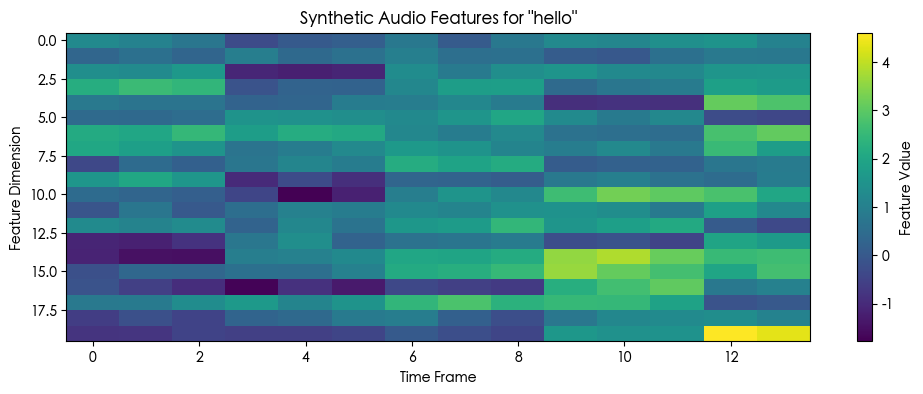

In [4]:
def generate_audio_features(text, frames_per_char=3, feature_dim=20):
    """
    Simulate audio features (e.g., MFCCs)
    In reality: extract from raw audio
    """
    # Convert text to indices
    char_indices = [char_to_idx[c] for c in text]
    
    # Generate features for each character (repeated frames)
    features = []
    for char_idx in char_indices:
        # Create feature vector for this character
        char_feature = np.random.randn(feature_dim) + char_idx * 0.1
        
        # Repeat for multiple frames (simulate speaking duration)
        num_frames = np.random.randint(frames_per_char - 1, frames_per_char + 2)
        for _ in range(num_frames):
            # Add noise
            features.append(char_feature + np.random.randn(feature_dim) * 0.3)
    
    return np.array(features)

# Generate sample
text = "hello"
features = generate_audio_features(text)

print(f"Text: '{text}'")
print(f"Text length: {len(text)} characters")
print(f"Audio features: {features.shape} (frames × features)")

# Visualize
plt.figure(figsize=(12, 4))
plt.imshow(features.T, cmap='viridis', aspect='auto')
plt.colorbar(label='Feature Value')
plt.xlabel('Time Frame')
plt.ylabel('Feature Dimension')
plt.title(f'Synthetic Audio Features for "{text}"')
plt.show()

## 简单RNN声学模型

In [5]:
class AcousticModel:
    """RNN that outputs character probabilities per frame"""
    def __init__(self, feature_dim, hidden_size, vocab_size):
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        # RNN weights
        self.W_xh = np.random.randn(hidden_size, feature_dim) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b_h = np.zeros((hidden_size, 1))
        
        # Output layer
        self.W_out = np.random.randn(vocab_size, hidden_size) * 0.01
        self.b_out = np.zeros((vocab_size, 1))
    
    def forward(self, features):
        """
        features: (num_frames, feature_dim)
        Returns: (num_frames, vocab_size) - log probabilities
        """
        h = np.zeros((self.hidden_size, 1))
        outputs = []
        
        for t in range(len(features)):
            x = features[t:t+1].T  # (feature_dim, 1)
            
            # RNN update
            h = np.tanh(np.dot(self.W_xh, x) + np.dot(self.W_hh, h) + self.b_h)
            
            # Output (logits)
            logits = np.dot(self.W_out, h) + self.b_out
            
            # Log softmax
            log_probs = logits - np.log(np.sum(np.exp(logits)))
            outputs.append(log_probs.flatten())
        
        return np.array(outputs)  # (num_frames, vocab_size)

# Create model
feature_dim = 20
hidden_size = 32
vocab_size = len(vocab)

model = AcousticModel(feature_dim, hidden_size, vocab_size)

# Test forward pass
log_probs = model.forward(features)
print(f"\nAcoustic model output: {log_probs.shape}")
print(f"Each frame has probability distribution over {vocab_size} characters")


Acoustic model output: (14, 28)
Each frame has probability distribution over 28 characters


## CTC前向算法（简化版）

计算给定帧级预测的目标序列概率

In [6]:
def ctc_loss_naive(log_probs, target, blank_idx):
    """
    Simplified CTC loss computation
    
    log_probs: (T, vocab_size) - log probabilities per frame
    target: list of character indices (without blanks)
    blank_idx: index of blank symbol
    
    This is a simplified version - full CTC uses dynamic programming
    """
    T = len(log_probs)
    U = len(target)
    
    # Insert blanks between characters: a → ε a ε b → ε a ε b ε
    extended_target = [blank_idx]
    for t in target:
        extended_target.extend([t, blank_idx])
    S = len(extended_target)
    
    # Forward algorithm with dynamic programming
    # alpha[t, s] = prob of being at position s at time t
    log_alpha = np.ones((T, S)) * -np.inf
    
    # Initialize
    log_alpha[0, 0] = log_probs[0, extended_target[0]]
    if S > 1:
        log_alpha[0, 1] = log_probs[0, extended_target[1]]
    
    # Forward pass
    for t in range(1, T):
        for s in range(S):
            label = extended_target[s]
            
            # Option 1: stay at same label (or blank)
            candidates = [log_alpha[t-1, s]]
            
            # Option 2: transition from previous label
            if s > 0:
                candidates.append(log_alpha[t-1, s-1])
            
            # Option 3: skip blank (if current is not blank and different from prev)
            if s > 1 and label != blank_idx and extended_target[s-2] != label:
                candidates.append(log_alpha[t-1, s-2])
            
            # Log-sum-exp for numerical stability
            log_alpha[t, s] = np.logaddexp.reduce(candidates) + log_probs[t, label]
    
    # Final probability: sum over last two positions (with/without final blank)
    log_prob = np.logaddexp(log_alpha[T-1, S-1], log_alpha[T-1, S-2] if S > 1 else -np.inf)
    
    # CTC loss is negative log probability
    return -log_prob, log_alpha

# Test CTC loss
target = [char_to_idx[c] for c in "hi"]
loss, alpha = ctc_loss_naive(log_probs, target, blank_idx)

print(f"\nTarget: 'hi'")
print(f"CTC Loss: {loss:.4f}")
print(f"Log probability: {-loss:.4f}")


Target: 'hi'
CTC Loss: 39.1446
Log probability: -39.1446


## 可视化CTC路径

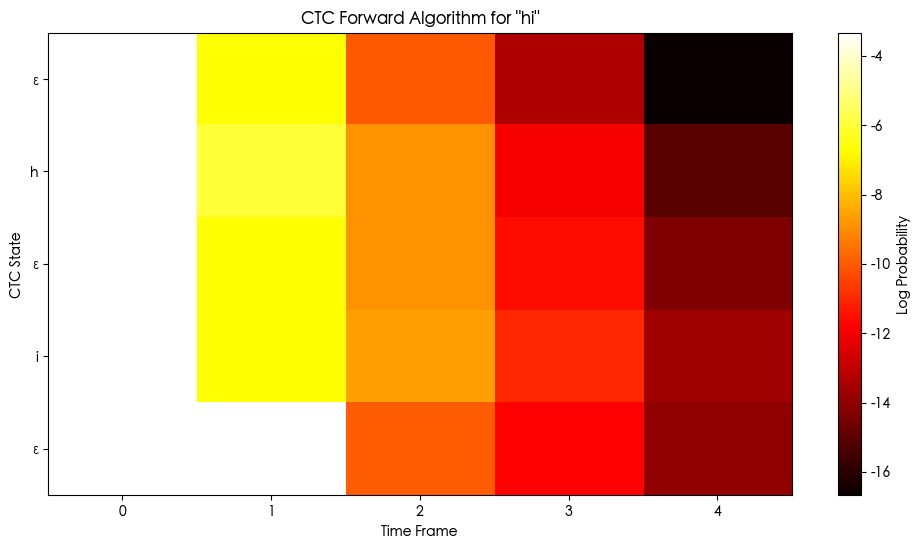


Brighter cells = higher probability paths
CTC explores all valid alignments!


In [7]:
# Visualize forward probabilities (alpha)
target_str = "hi"
target_indices = [char_to_idx[c] for c in target_str]

# Recompute with smaller example
small_features = generate_audio_features(target_str, frames_per_char=2)
small_log_probs = model.forward(small_features)
loss, alpha = ctc_loss_naive(small_log_probs, target_indices, blank_idx)

# Create extended target for visualization
extended = [blank_idx]
for t in target_indices:
    extended.extend([t, blank_idx])
extended_labels = [idx_to_char[i] for i in extended]

plt.figure(figsize=(12, 6))
plt.imshow(alpha.T, cmap='hot', aspect='auto', interpolation='nearest')
plt.colorbar(label='Log Probability')
plt.xlabel('Time Frame')
plt.ylabel('CTC State')
plt.title(f'CTC Forward Algorithm for "{target_str}"')
plt.yticks(range(len(extended_labels)), extended_labels)
plt.show()

print("\nBrighter cells = higher probability paths")
print("CTC explores all valid alignments!")

## 贪婪CTC解码

In [8]:
def greedy_decode(log_probs, blank_idx):
    """
    Greedy decoding: pick most likely character at each frame
    Then collapse using CTC rules
    """
    # Get most likely character per frame
    predictions = np.argmax(log_probs, axis=1)
    
    # Collapse
    decoded = collapse_ctc(predictions.tolist(), blank_idx)
    
    return decoded, predictions

# Test decoding
test_text = "hello"
test_features = generate_audio_features(test_text)
test_log_probs = model.forward(test_features)

decoded, raw_predictions = greedy_decode(test_log_probs, blank_idx)

print(f"True text: '{test_text}'")
print(f"\nFrame-by-frame predictions:")
print(''.join([idx_to_char[i] for i in raw_predictions]))
print(f"\nAfter CTC collapse:")
print(''.join([idx_to_char[i] for i in decoded]))
print(f"\n(Model is untrained, so prediction is random)")

True text: 'hello'

Frame-by-frame predictions:
pyypqqqfffygyyy

After CTC collapse:
pypqfygy

(Model is untrained, so prediction is random)


## 可视化预测与真值对比

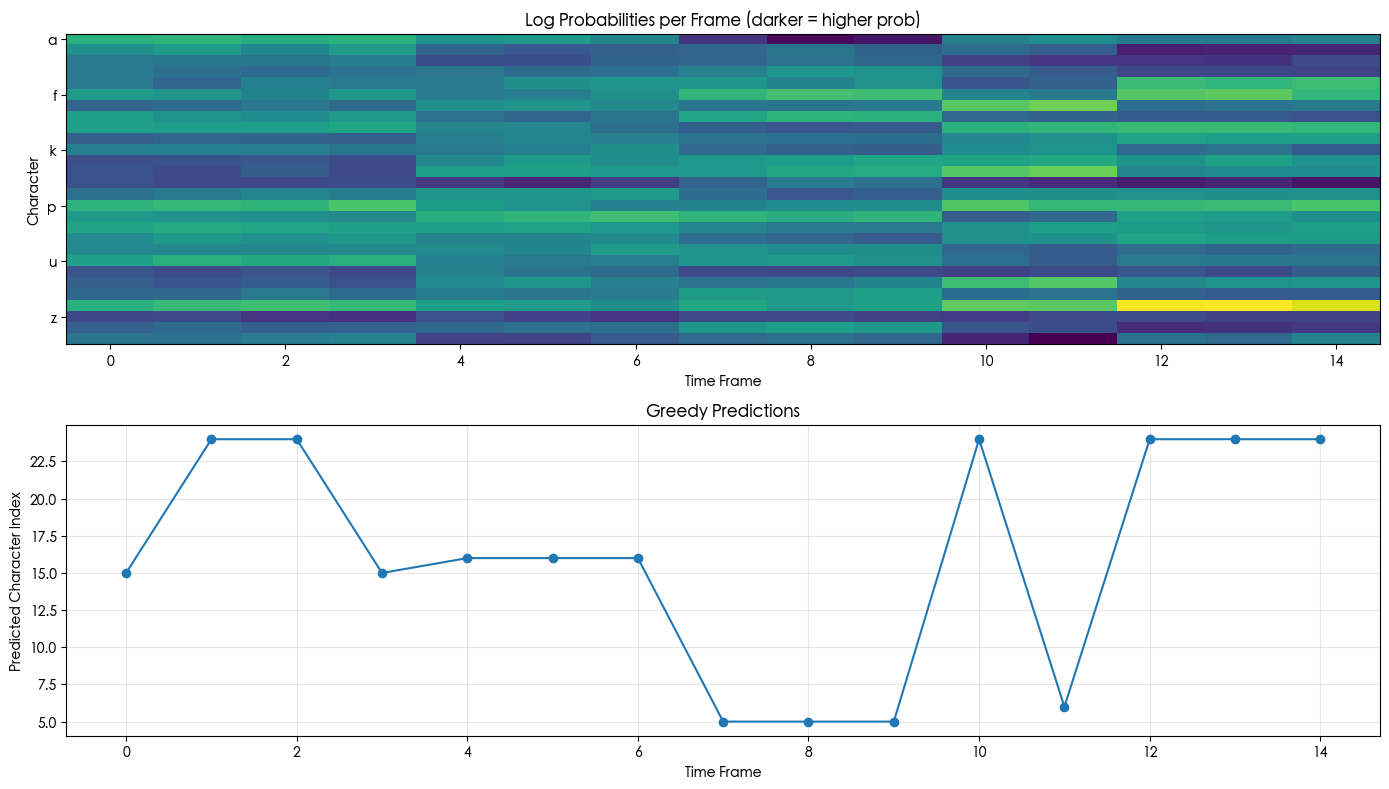

In [9]:
# Visualize probability distribution over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot log probabilities
ax1.imshow(test_log_probs.T, cmap='viridis', aspect='auto')
ax1.set_ylabel('Character')
ax1.set_xlabel('Time Frame')
ax1.set_title('Log Probabilities per Frame (darker = higher prob)')
ax1.set_yticks(range(0, vocab_size, 5))
ax1.set_yticklabels([vocab[i] for i in range(0, vocab_size, 5)])

# Plot predictions
ax2.plot(raw_predictions, 'o-', markersize=6)
ax2.set_xlabel('Time Frame')
ax2.set_ylabel('Predicted Character Index')
ax2.set_title('Greedy Predictions')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 核心要点

### CTC问题：
- **未知对齐**：不知道哪些音频帧对应哪些字符
- **可变长度**：音频帧数多于输出字符数
- **无分割**：不知道词/字符从哪里开始/结束

### CTC解决方案：
1. **空白符号（ε）**：允许重复和静音
2. **所有对齐**：对所有有效路径的概率求和
3. **端到端**：无需帧级标签即可训练

### CTC规则：
```
1. 插入空白："cat" → "ε c ε a ε t ε"
2. 任何折叠到目标的路径都有效
3. 对所有有效路径的概率求和
```

### 前向算法：
- 在时间和标签位置上进行动态规划
- α[t, s] = 在时间t处于位置s的概率
- 三种转换：保持、前移、跳过空白

### 损失：
$$\mathcal{L}_{CTC} = -\log P(y|x) = -\log \sum_{\pi \in \mathcal{B}^{-1}(y)} P(\pi|x)$$

其中 $\mathcal{B}^{-1}(y)$ 是所有折叠到y的对齐

### 解码：
1. **贪婪**：每帧选择最佳字符，然后折叠
2. **束搜索**：保留top-k假设
3. **前缀束搜索**：更适合CTC（生产环境使用）

### Deep Speech 2架构：
```
音频 → 特征（MFCC/频谱图）
  ↓
卷积层（捕获局部模式）
  ↓
RNN层（双向GRU/LSTM）
  ↓
全连接层
  ↓
Softmax（字符概率）
  ↓
CTC损失
```

### 优势：
- ✅ 无需对齐
- ✅ 端到端可训练
- ✅ 处理可变长度
- ✅ 适用于任何序列任务

### 局限：
- ❌ 独立性假设（每帧独立）
- ❌ 不能很好地建模输出依赖
- ❌ 只支持单调对齐

### 现代替代方案：
- **基于注意力**：带注意力的Seq2seq（Listen, Attend, Spell）
- **Transducer**：RNN-T结合了CTC+注意力
- **Transformers**：Wav2Vec 2.0、Whisper

### 应用：
- 语音识别
- 手写识别
- OCR
- 关键词检测
- 任何有未知对齐的任务！